In [38]:
import pandas as pd
import librosa
import numpy as np

# Load the CSV file
df = pd.read_csv('C:/Users/Edward/Dropbox/MPI/Wingbeat/Arizona/flightcage/example_flight_cage_fleatag.csv')

# Get the 'z' column values
z = df['accZ_mg'].values**3

# Convert to floating point
z = z.astype(np.float32)
print(z)
# Perform the STFT
D = librosa.stft(z)

# Convert to decibels
D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Estimate the frequency
frequencies = librosa.core.fft_frequencies(sr=54, n_fft=1 + 2 * (D.shape[0] - 1))

[ 8.4390861e+08  9.2971418e+08  9.2971418e+08 ... -1.2284809e+09
 -1.1216223e+09 -1.1216223e+09]


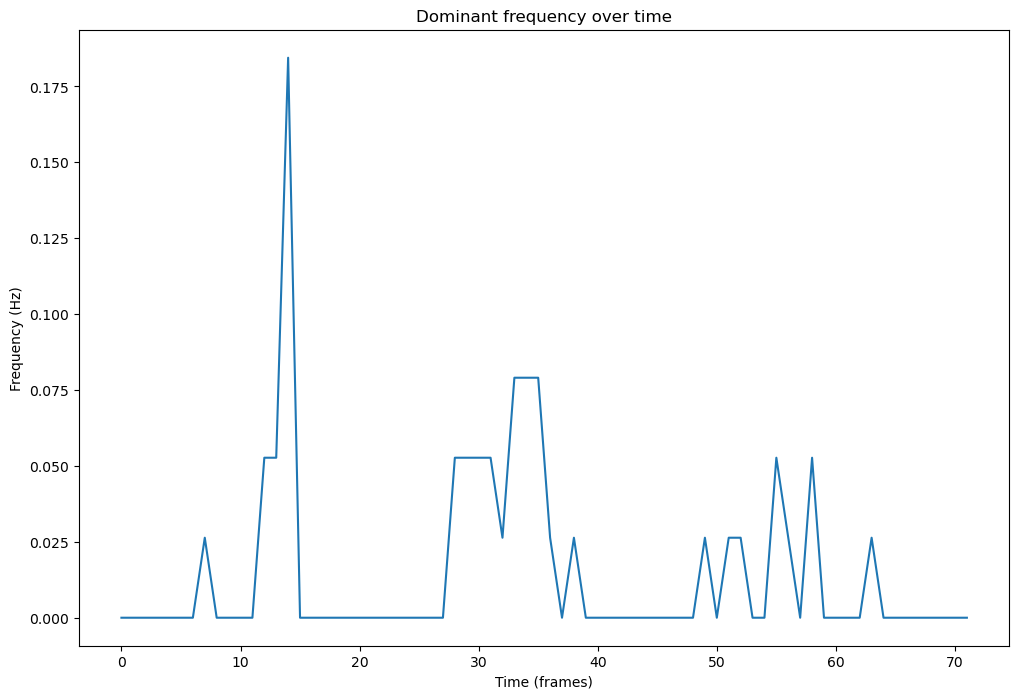

In [39]:
import matplotlib.pyplot as plt

# Compute the spectrum magnitude
magnitude = np.abs(D)

# Find the index of the maximum magnitude
dominant_index = np.argmax(magnitude, axis=0)

# Get the dominant frequency for each frame
dominant_frequency = frequencies[dominant_index]

# Plot the dominant frequency
plt.figure(figsize=(12, 8))
plt.plot(dominant_frequency)
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (Hz)')
plt.title('Dominant frequency over time')
plt.show()

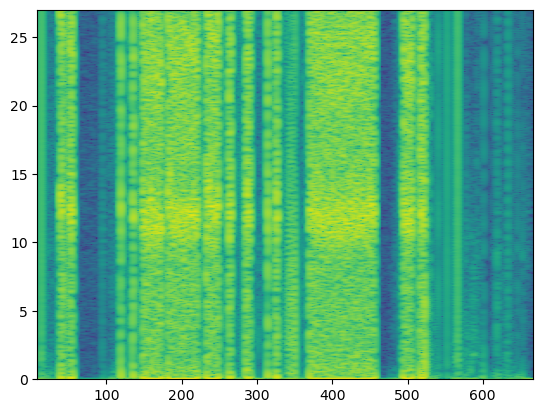

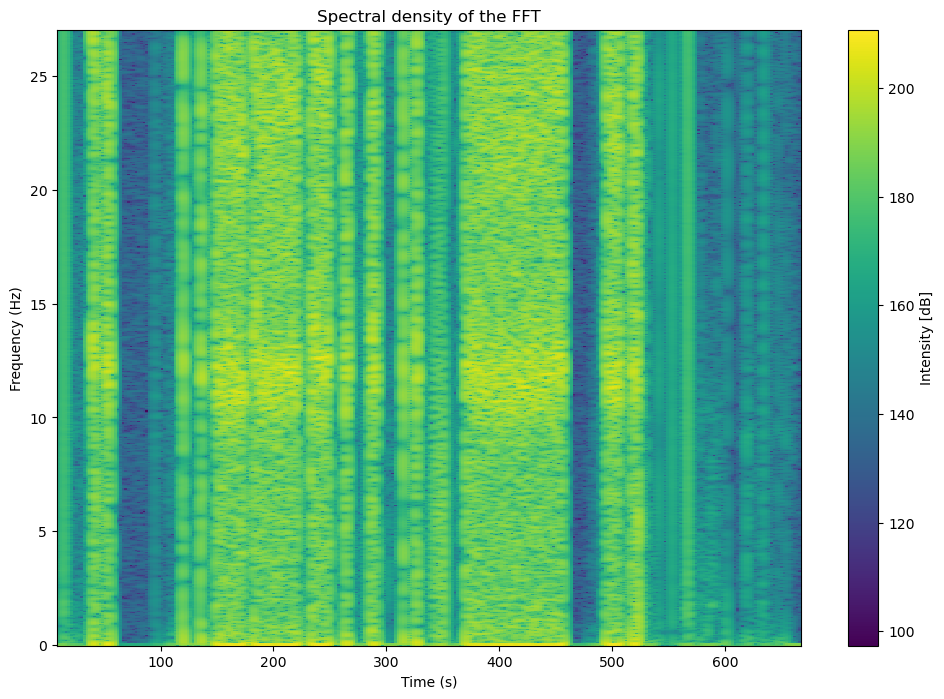

In [40]:
import matplotlib.pyplot as plt

# Compute the FFT
D = librosa.stft(z)

# Compute the spectral density
Pxx, freqs, bins, im = plt.specgram(z, NFFT=1024, Fs=54, noverlap=900)

# Plot the spectral density
plt.figure(figsize=(12, 8))
plt.pcolormesh(bins, freqs, 10 * np.log10(Pxx))
plt.colorbar(label='Intensity [dB]')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral density of the FFT')
plt.show()

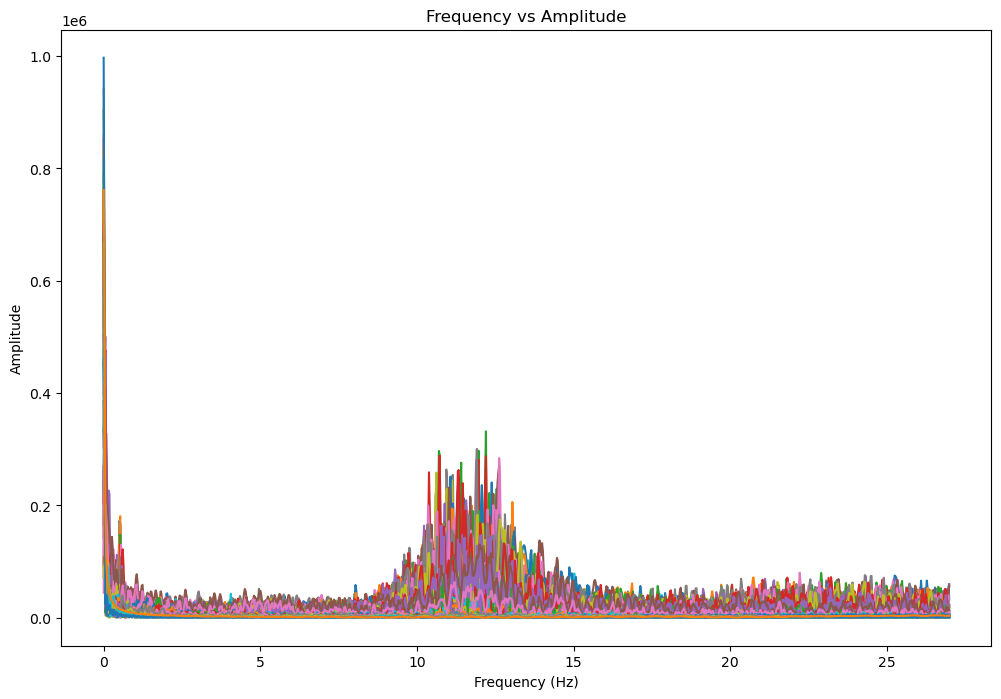

In [32]:
import matplotlib.pyplot as plt

# Compute the magnitude of the FFT
magnitude = np.abs(D)

# Plot frequency vs amplitude
plt.figure(figsize=(12, 8))
plt.plot(frequencies, magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency vs Amplitude')
plt.show()

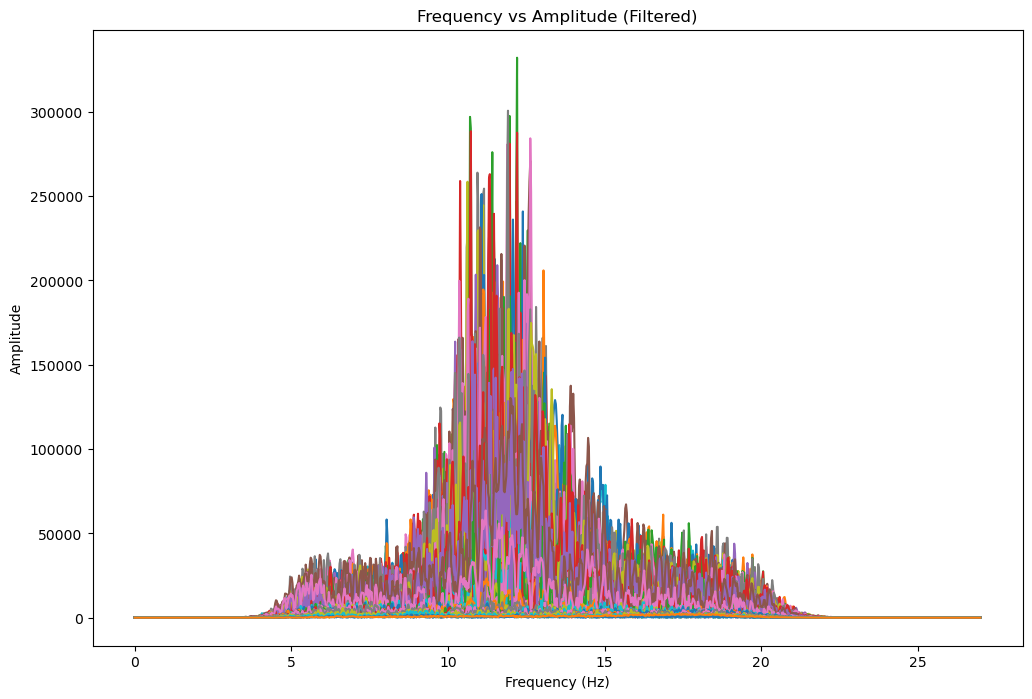

95% confidence interval for the peak amplitude frequency: (-33135.96299046466, 53408.33721859171)


In [33]:
from scipy.signal import butter, filtfilt
from scipy import stats

# Define the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Apply the bandpass filter
filtered_z = bandpass_filter(z, 5, 20, 54)

# Perform the STFT on the filtered signal
D_filtered = librosa.stft(filtered_z)

# Compute the magnitude of the FFT
magnitude_filtered = np.abs(D_filtered)

# Plot frequency vs amplitude for the filtered signal
plt.figure(figsize=(12, 8))
plt.plot(frequencies, magnitude_filtered)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency vs Amplitude (Filtered)')
plt.show()

# Estimate the peak amplitude frequency with 95% confidence intervals
confidence_interval = stats.norm.interval(0.95, loc=np.mean(magnitude_filtered), scale=np.std(magnitude_filtered))
print(f"95% confidence interval for the peak amplitude frequency: {confidence_interval}")

In [35]:
# Perform the STFT on the filtered signal
D_filtered = librosa.stft(filtered_z)

# Compute the frequencies for the filtered signal
frequencies_filtered = librosa.core.fft_frequencies(sr=54, n_fft=1 + 2 * (D_filtered.shape[0] - 1))

# Find the index of the maximum magnitude
peak_index = np.argmax(magnitude_filtered)

# Get the peak frequency
peak_frequency = frequencies_filtered[peak_index]

print(f"Peak frequency: {peak_frequency} Hz")

IndexError: index 33358 is out of bounds for axis 0 with size 1025

[]
[]


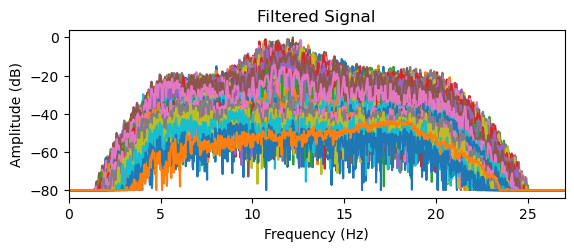

In [25]:
import pandas as pd
import librosa
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('C:/Users/Edward/Dropbox/MPI/Wingbeat/Arizona/flightcage/example_flight_cage_fleatag.csv')

# Get the 'z' column values
z = df['accZ_mg'].values

# Convert to floating point
z = z.astype(np.float32)

# Perform the STFT
D = librosa.stft(z)

# Convert to decibels
D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Estimate the frequency
frequencies = librosa.core.fft_frequencies(sr=22050, n_fft=1 + 2 * (D.shape[0] - 1))

# Apply bandpass filter
fs = 54
lowcut = 5
highcut = 20
order = 5

nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(order, [low, high], btype='band')
filtered_signal = signal.lfilter(b, a, z)

# Handle non-finite values in the filtered signal
filtered_signal[np.logical_not(np.isfinite(filtered_signal))] = 0

# Perform STFT on filtered signal
D_filtered = librosa.stft(filtered_signal)
D_db_filtered = librosa.amplitude_to_db(abs(D_filtered), ref=np.max)

# Estimate the frequency of the filtered signal
frequencies_filtered = librosa.core.fft_frequencies(sr=fs, n_fft=1 + 2 * (D_filtered.shape[0] - 1))

# Plot filtered signal
plt.subplot(2, 1, 2)
plt.plot(frequencies_filtered, D_db_filtered)
plt.title('Filtered Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.xlim(0, fs / 2)

# Reshape filtered signal to 1-D array
D_db_filtered_1d = D_db_filtered.ravel()

# Estimate peak amplitude frequency with 95% confidence intervals
peaks, properties = signal.find_peaks(D_db_filtered_1d, prominence=10)  # Adjust prominence value as needed

# Check for valid indices
valid_peaks = np.where(peaks < len(frequencies_filtered))[0]
peaks = peaks[valid_peaks]
properties = {key: value[valid_peaks] for key, value in properties.items()}

print(peaks)

peak_frequencies = frequencies_filtered[peaks]
peak_amplitudes = D_db_filtered_1d[peaks]
confidence_intervals = properties['prominences']
print(confidence_intervals)

for freq, amp, ci in zip(peak_frequencies, peak_amplitudes, confidence_intervals):
    print(f"Peak Frequency: {freq:.2f} Hz, Amplitude: {amp:.2f} dB, Confidence Intervals: {ci:.2f}")
    plt.axvline(x=freq, color='r', linestyle='--')
    plt.axvline(x=freq - ci, color='g', linestyle='--')
    plt.axvline(x=freq + ci, color='g', linestyle='--')

# Adjust x-limits for the plot
plt.xlim(0, fs / 2)

plt.show()
